In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim




In [3]:
imagenames = list(os.listdir("/content/drive/MyDrive/temp/train_2"))
imp_imgs_names = [name for name in imagenames if "imp" in name][:300]
sur_imgs_names = [name for name in imagenames if "sur" in name][:300]
images=[]

for name in imp_imgs_names:
  img = cv2.imread(f'/content/drive/MyDrive/temp/train_2/{name}')
  img = cv2.resize(img,(50, 50))
  images.append([np.array(img), np.eye(2)[0]])

for name in sur_imgs_names:
  img = cv2.imread(f'/content/drive/MyDrive/temp/train_2/{name}')
  img = cv2.resize(img,(50, 50))
  images.append([np.array(img), np.eye(2)[1]])

np.random.shuffle(images)
print(len(images))
#with open("imgs.pickle", "wb") as handle:
#  pickle.dump(images, handle)
np.save("training_data.npy", images)

600


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [4]:
training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))
print(training_data[4][0].shape)

600
(50, 50, 3)


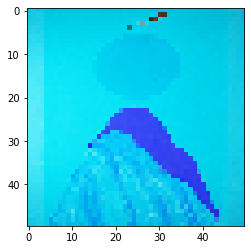

In [5]:
plt.imshow(training_data[5][0])


In [6]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 5)
    self.conv2 = nn.Conv2d(32, 64, 5)
    self.conv3 = nn.Conv2d(64, 128, 5)

    x = torch.randn(3,50,50).view(-1,3,50,50)
    self._to_linear = None
    self.convs(x)
    self.fc1 = nn.Linear(self._to_linear, 512)
    self.fc2 = nn.Linear(512, 2)

  def convs(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))

    #print(x[0].shape)

    if self._to_linear is None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
    return x

  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return F.softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [7]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()


X = torch.Tensor([i[0] for i in training_data]).view(-1, 3, 50, 50)
print(X.shape)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)



torch.Size([600, 3, 50, 50])
60


In [8]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

540
60


In [9]:
BATCH_SIZE = 500
EPOCHS = 100

for epoch in range(EPOCHS):
  for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
    print(train_X[i:i+BATCH_SIZE].view(-1, 50, 50).shape)
    batch_X = train_X[i:i+BATCH_SIZE].view(-1, 3, 50, 50)
    batch_y = train_y[i:i+BATCH_SIZE]

    net.zero_grad()
    outputs = net(batch_X)
    loss = loss_function(outputs, batch_y )
    loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch}. Loss: {loss}")

  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 0. Loss: 0.2482648342847824
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 1. Loss: 0.24682708084583282
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 2. Loss: 0.25002673268318176
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 3. Loss: 0.2493888884782791
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 4. Loss: 0.24849240481853485
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 5. Loss: 0.24707531929016113
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 6. Loss: 0.24354131519794464
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


torch.Size([120, 50, 50])
Epoch: 7. Loss: 0.24097497761249542


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


torch.Size([120, 50, 50])
Epoch: 8. Loss: 0.2305784523487091


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 9. Loss: 0.22547845542430878
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


torch.Size([120, 50, 50])
Epoch: 10. Loss: 0.21305735409259796


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 11. Loss: 0.21311840415000916
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 12. Loss: 0.18660978972911835
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


torch.Size([120, 50, 50])
Epoch: 13. Loss: 0.17911984026432037


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 14. Loss: 0.18858247995376587
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


torch.Size([120, 50, 50])
Epoch: 15. Loss: 0.1750067174434662


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 16. Loss: 0.14160579442977905
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 17. Loss: 0.13122698664665222
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 18. Loss: 0.1549457609653473
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]

torch.Size([120, 50, 50])



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 19. Loss: 0.144357368350029
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]

torch.Size([120, 50, 50])



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 20. Loss: 0.13636142015457153
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 21. Loss: 0.10816142708063126
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]

torch.Size([120, 50, 50])
Epoch: 22. Loss: 0.09695205837488174



  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]

torch.Size([120, 50, 50])



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 23. Loss: 0.0976860374212265
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]

torch.Size([120, 50, 50])



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 24. Loss: 0.08762601763010025
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 25. Loss: 0.07739435136318207
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 26. Loss: 0.06292027980089188
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 27. Loss: 0.06237056851387024
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 28. Loss: 0.04872758314013481
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 29. Loss: 0.04975451901555061
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 30. Loss: 0.03790685907006264
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


torch.Size([120, 50, 50])
Epoch: 31. Loss: 0.0359099879860878


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 32. Loss: 0.04363836720585823
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 33. Loss: 0.03042449615895748


 50%|█████     | 1/2 [00:02<00:02,  2.50s/it]

torch.Size([1500, 50, 50])
torch.Size([120, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 34. Loss: 0.037346191704273224
torch.Size([1500, 50, 50])


 50%|█████     | 1/2 [00:02<00:02,  2.40s/it]

torch.Size([120, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 35. Loss: 0.05270920321345329
torch.Size([1500, 50, 50])


 50%|█████     | 1/2 [00:02<00:02,  2.47s/it]

torch.Size([120, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 36. Loss: 0.022399628534913063
torch.Size([1500, 50, 50])


 50%|█████     | 1/2 [00:02<00:02,  2.66s/it]

torch.Size([120, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 37. Loss: 0.02174854651093483
torch.Size([1500, 50, 50])


 50%|█████     | 1/2 [00:02<00:02,  2.87s/it]

torch.Size([120, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 38. Loss: 0.023531831800937653
torch.Size([1500, 50, 50])


 50%|█████     | 1/2 [00:02<00:02,  2.50s/it]

torch.Size([120, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 39. Loss: 0.019008571282029152
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.43s/it]

torch.Size([120, 50, 50])



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 40. Loss: 0.016195982694625854
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]

torch.Size([120, 50, 50])
Epoch: 41. Loss: 0.017309654504060745



  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]

torch.Size([120, 50, 50])
Epoch: 42. Loss: 0.03179585188627243



  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 43. Loss: 0.018012357875704765
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


torch.Size([120, 50, 50])
Epoch: 44. Loss: 0.06523029506206512


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


torch.Size([120, 50, 50])
Epoch: 45. Loss: 0.08750061690807343


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 46. Loss: 0.0560518279671669
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.63s/it]

torch.Size([120, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 47. Loss: 0.029784519225358963
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]

torch.Size([120, 50, 50])
Epoch: 48. Loss: 0.023927897214889526



  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 49. Loss: 0.051125068217515945
torch.Size([1500, 50, 50])


 50%|█████     | 1/2 [00:02<00:02,  2.25s/it]

torch.Size([120, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 50. Loss: 0.03608689457178116
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 51. Loss: 0.026228222995996475
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 52. Loss: 0.03564181178808212
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 53. Loss: 0.020902514457702637
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 54. Loss: 0.02191011607646942
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 55. Loss: 0.012637943029403687


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


torch.Size([1500, 50, 50])
torch.Size([120, 50, 50])
Epoch: 56. Loss: 0.010354222729802132


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.61s/it]

torch.Size([120, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 57. Loss: 0.009101229719817638
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]

torch.Size([120, 50, 50])
Epoch: 58. Loss: 0.009740276262164116



  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]

torch.Size([120, 50, 50])
Epoch: 59. Loss: 0.009019402787089348



  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 60. Loss: 0.007840143516659737


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]

torch.Size([1500, 50, 50])
torch.Size([120, 50, 50])



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 61. Loss: 0.014257567934691906
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]

torch.Size([120, 50, 50])
Epoch: 62. Loss: 0.010502181947231293



  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]

torch.Size([120, 50, 50])



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 63. Loss: 0.026084333658218384
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 64. Loss: 0.009306438267230988
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 65. Loss: 0.01704237051308155
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 66. Loss: 0.008588004857301712
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 67. Loss: 0.010287116281688213
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]

torch.Size([120, 50, 50])
Epoch: 68. Loss: 0.008407419547438622



  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]

torch.Size([120, 50, 50])



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 69. Loss: 0.006327914539724588
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 70. Loss: 0.006037197541445494
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.55s/it]

torch.Size([120, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 71. Loss: 0.0051149483770132065
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]

torch.Size([120, 50, 50])
Epoch: 72. Loss: 0.005848848260939121



  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 73. Loss: 0.006441295146942139
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.63s/it]

torch.Size([120, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 74. Loss: 0.0038273283280432224
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 75. Loss: 0.0030411200132220984
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]

torch.Size([120, 50, 50])



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 76. Loss: 0.0026661320589482784
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]

torch.Size([120, 50, 50])



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 77. Loss: 0.0023977088276296854
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 78. Loss: 0.0026220744475722313
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]

torch.Size([120, 50, 50])



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 79. Loss: 0.0023514525964856148
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


torch.Size([120, 50, 50])
Epoch: 80. Loss: 0.001870706444606185


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 81. Loss: 0.0021187742240726948
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 82. Loss: 0.007961507886648178
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 83. Loss: 0.006375881377607584
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]

torch.Size([120, 50, 50])



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 84. Loss: 0.011369224637746811
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 85. Loss: 0.003451849101111293
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]

torch.Size([120, 50, 50])
Epoch: 86. Loss: 0.010300735011696815



  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]

torch.Size([120, 50, 50])



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 87. Loss: 0.004822826478630304
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]

torch.Size([120, 50, 50])
Epoch: 88. Loss: 0.008946281857788563



  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]

torch.Size([120, 50, 50])
Epoch: 89. Loss: 0.004357989877462387



  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 90. Loss: 0.0033638160675764084
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 91. Loss: 0.003929197322577238


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])
torch.Size([120, 50, 50])
Epoch: 92. Loss: 0.002465061843395233
torch.Size([1500, 50, 50])


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


torch.Size([120, 50, 50])
Epoch: 93. Loss: 0.0019439533352851868


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1500, 50, 50])


 50%|█████     | 1/2 [00:02<00:02,  2.24s/it]

torch.Size([120, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 94. Loss: 0.002802688628435135
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 95. Loss: 0.0034875720739364624
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 96. Loss: 0.0014556532260030508
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 97. Loss: 0.0011236070422455668
torch.Size([1500, 50, 50])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([120, 50, 50])
Epoch: 98. Loss: 0.0011802662629634142


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

torch.Size([1500, 50, 50])
torch.Size([120, 50, 50])
Epoch: 99. Loss: 0.0009320879471488297


In [10]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 3 , 50, 50))[0]
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 60/60 [00:00<00:00, 327.12it/s]

Accuracy:  0.667


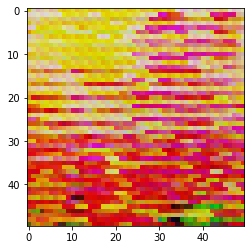

In [15]:
plt.imshow(test_X[5].permute(1, 2, 0)  )
plt.show()